<img src="../LogoUTN.jpg" align="right" width="150" /> 

### Procesamiento Digital de Señales - 2024

# Trabajo Práctico Nº6: Ventanas en acción
### Juan Manuel Ronchetti

## Introduccion

En este notebook, se pidio generar la siguiente señal:

$$
x(k) = a_0 \cdot \sin(\Omega_1 \cdot k)
$$


siendo

- $a_1 = 2$
- $ \Omega_1 = \Omega_0 + f_r \cdot 2\pi N $
- $ \Omega_0 = \frac{\pi}{2} $

y la variable aleatoria definida por la siguiente distribución de probabilidad:

$$
f_r \sim U(-2, 2)
$$

Considerar 200 realizaciones (muestras tomadas de $f_r$ para cada ventana analizada en la TS6. Se pide entonces:

#### Grafique los histogramas de 

$$
|X_{iw}(\Omega_0)|
$$


siendo

$$
|X_{iw}(\Omega)| = |F\{x(k) \cdot w_i(k)\}|
$$


para la i-ésima ventana.

Grafique los 3 historamas juntos, o cuide que todos los gráficos tengan el mismo rango de valores en $X$ para facilitar la comparación visual.

#### Calcule experimentalmente el sesgo y la varianza del siguiente estimador:

$$
\hat{a}_0 = |X_{iw}(\Omega_0)|
$$


siendo

$$
s_a = E\{\hat{a}_0\} - a_0
$$


$$
v_a = \text{var}\{\hat{a}_0\} = E\{(\hat{a}_0 - E\{\hat{a}_0\})^2\}
$$


y pueden aproximarse cuando consideramos los valores esperados como las medias muestrales:

$$
E\{\hat{a}_0\} = \mu_{\hat{a}} = \frac{1}{M} \sum_{j=0}^{M-1} \hat{a}_j
$$


$$
s_a = \mu_{\hat{a}} - a_0
$$


$$
v_a = \frac{1}{M} \sum_{j=0}^{M-1} (\hat{a}_j - \mu_{\hat{a}})^2
$$

## Preparacion de la simulacion

In [1]:
# -------------------------------------------------------------------------------
#                                   Imports
# -------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------
#                                   Parámetros
# -------------------------------------------------------------------------------

fs = 1000.0  # Frecuencia de muestreo (Hz)
N = 1000     # Cantidad de muestras
cant_realiz = 200  # Cantidad de realizaciones

# Frecuencia normalizada
f0 = fs / N  
ts = 1 / fs  
df = fs / N  

# Fijar SNR
SNR_db = 3  # SNR en dB
SNR = 10 ** (SNR_db / 10)  # Conversión a veces
a1 = 2
Ps = (a1 ** 2) / 2
Pr = Ps / SNR

# Histograma para almacenar resultados
a1_estimates = { 'Rectangular': [], 'Hann': [], 'Blackman': [], 'Flat-Top': [] }
last_signals = {}
last_ffts = {}

# Ventanas a aplicar
ventanas = {
    'Rectangular':  sig.boxcar(N),
    'Hann':         sig.hann(N),
    'Blackman':     sig.blackman(N),
    'Flat-Top':     sig.flattop(N)
}

# Colores para las ventanas
colores = {
    'Rectangular': 'blue',
    'Hann': 'orange',
    'Blackman': 'green',
    'Flat-Top': 'red'
}

## Simulacion

In [2]:
# -------------------------------------------------------------------------------
#                                   Simulacion
# -------------------------------------------------------------------------------

for window_name, window in ventanas.items():
    for realization in range(cant_realiz):
        # Generar ruido
        n = np.random.normal(0, np.sqrt(Pr), N)
        
        # Frecuencia aleatoria
        fr = np.random.uniform(-2, 2)
        w1 = N/4 + fr * df
        
        # Tiempo
        k = np.linspace(0, (N - 1) * ts, N).flatten()
        
        # Señal
        signal = a1 * np.sin(2 * np.pi * w1 * k) + n
        
        # Aplicar ventana a la señal
        windowed_signal = signal * ventanas[window_name]
        
        # FFT y estimación de a1
        fft_signal = np.abs(np.fft.fft(windowed_signal) / N)
        
        # Estimador en la frecuencia deseada (índice N/4)
        a1_estimate = ( fft_signal[int(N//4)] * 2 )
        
        # Almacenar estimaciones
        a1_estimates[window_name].append(a1_estimate)
        
        # Guardar solo la última señal y su FFT para cada ventana
        if realization == cant_realiz - 1:
            last_signals[window_name] = windowed_signal  # Guardar la señal con ventana aplicada
            last_ffts[window_name] = fft_signal

## Gráfico de señales y FFT

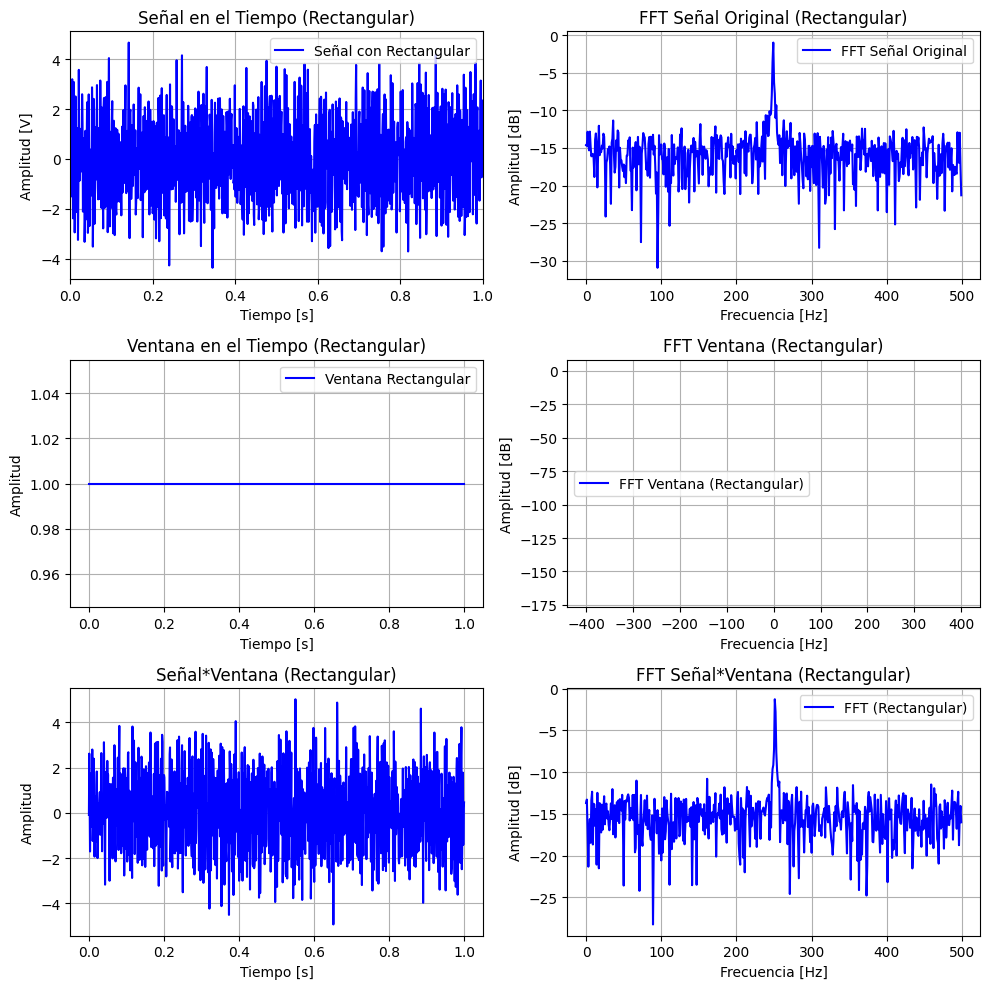

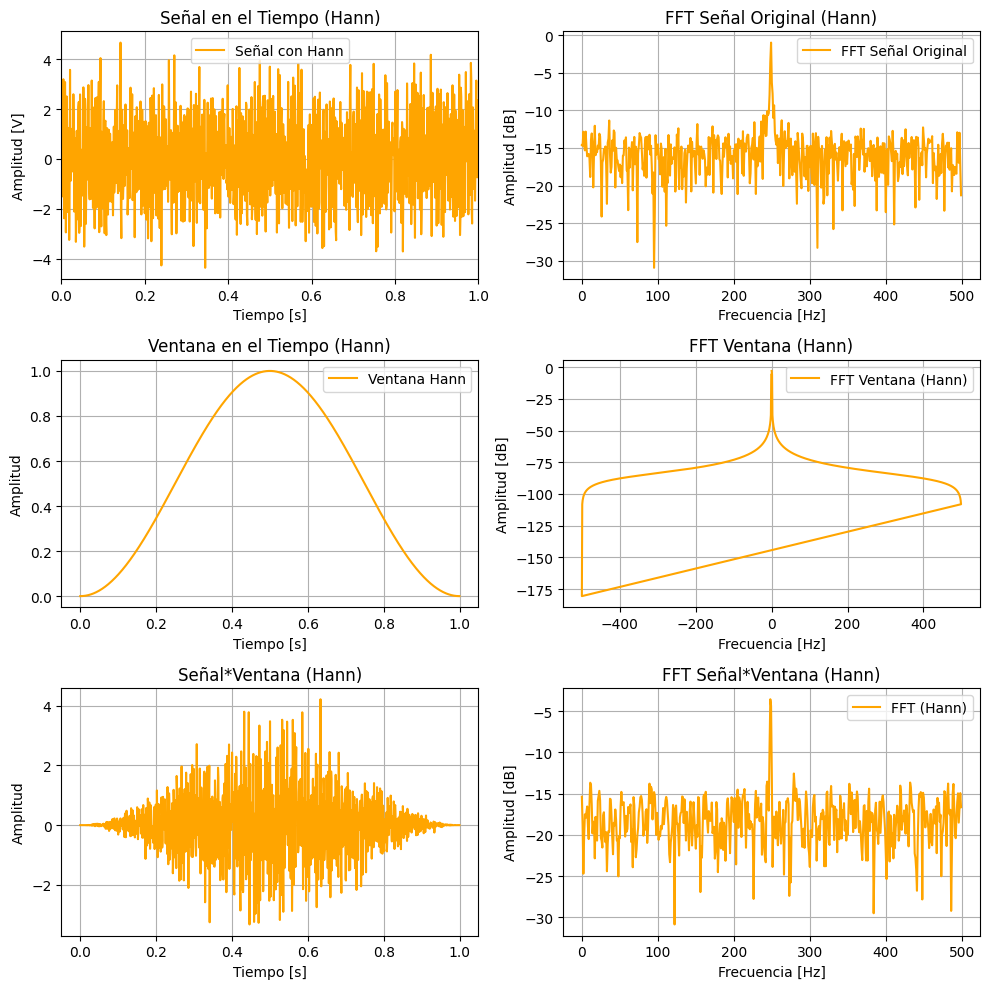

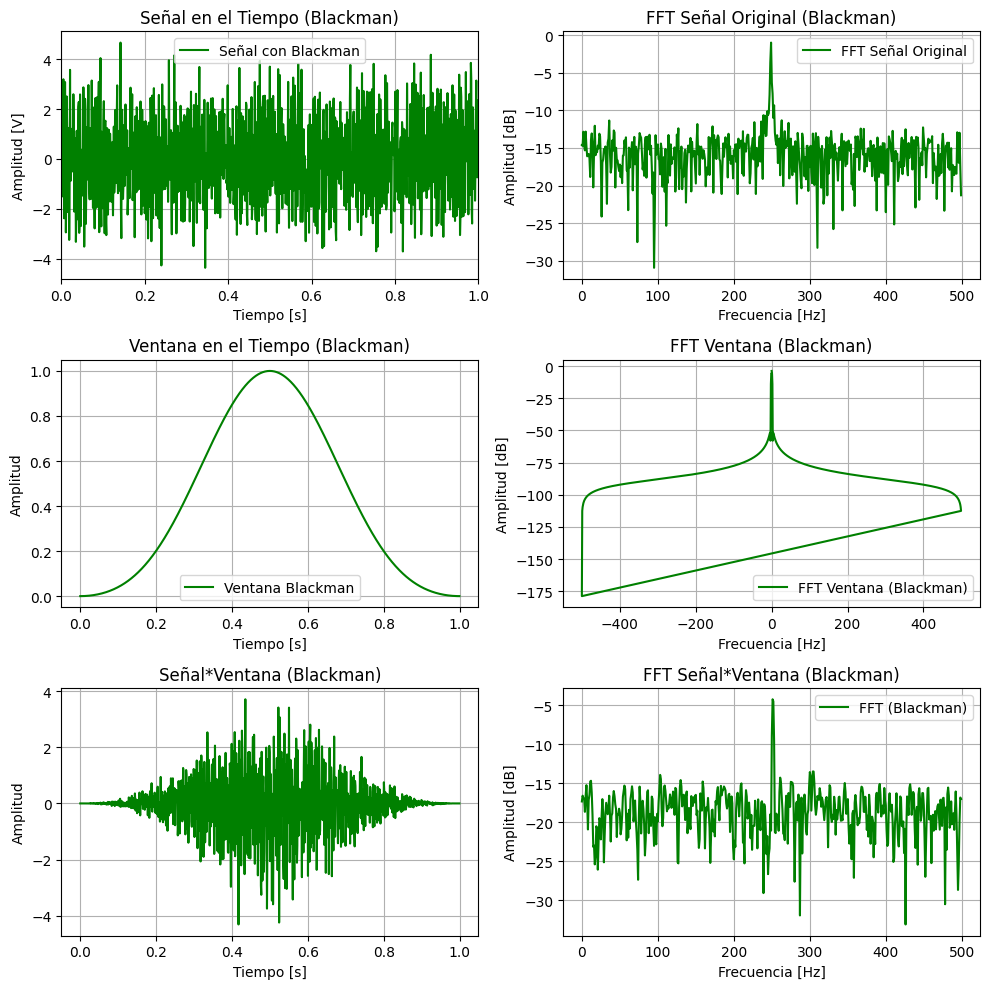

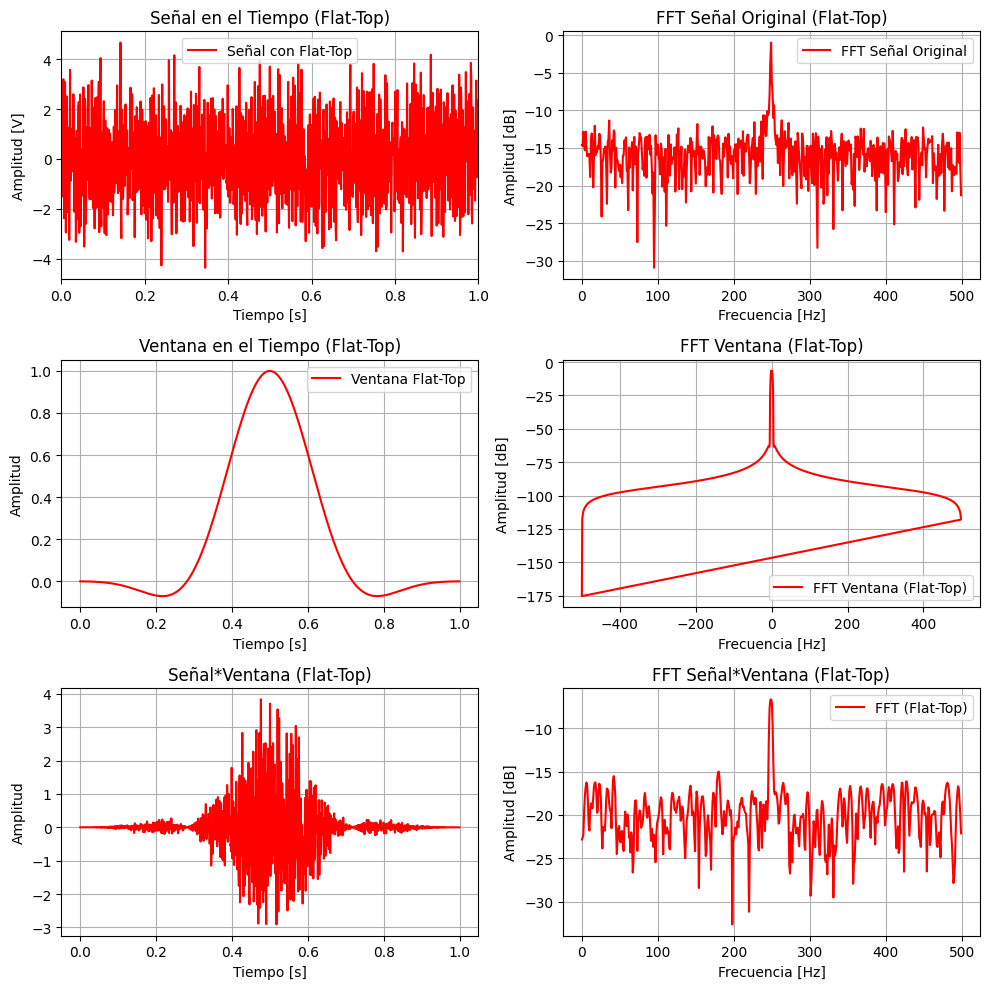

In [3]:
# -------------------------------------------------------------------------------
#                           Grafico de señales y FFTs
# -------------------------------------------------------------------------------

# Graficar señales y FFTs
for window_name in ventanas.keys():
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    frecuencias = np.fft.fftfreq(N, d=ts)

    # Señal en el tiempo
    axs[0, 0].plot(np.linspace(0, (N-1)*ts, N), signal, label=f'Señal con {window_name}', color=colores[window_name])
    axs[0, 0].set_title(f'Señal en el Tiempo ({window_name})')
    axs[0, 0].set_xlabel('Tiempo [s]')
    axs[0, 0].set_ylabel('Amplitud [V]')
    axs[0, 0].set_xlim(0, 1) 
    axs[0, 0].legend()
    axs[0, 0].grid()

    # FFT de la señal original (sin ventana)
    fft_original_signal = np.abs(np.fft.fft(signal) / N)
    axs[0, 1].plot(frecuencias[:N//2], 10*np.log10(fft_original_signal[:N//2]), label='FFT Señal Original', color=colores[window_name])
    axs[0, 1].set_title(f'FFT Señal Original ({window_name})')
    axs[0, 1].set_xlabel('Frecuencia [Hz]')
    axs[0, 1].set_ylabel('Amplitud [dB]')
    axs[0, 1].legend()
    axs[0, 1].grid()

    # Ventana en el tiempo
    axs[1, 0].plot(np.linspace(0, (N-1)*ts, N), ventanas[window_name], label=f'Ventana {window_name}', color=colores[window_name])
    axs[1, 0].set_title(f'Ventana en el Tiempo ({window_name})')
    axs[1, 0].set_xlabel('Tiempo [s]')
    axs[1, 0].set_ylabel('Amplitud')
    axs[1, 0].legend()
    axs[1, 0].grid()

    # FFT de la ventana en sí misma
    window = ventanas[window_name]
    fft_window = np.abs(np.fft.fft(window, N) / N)
    axs[1, 1].plot(frecuencias, 10*np.log10(fft_window), label=f'FFT Ventana ({window_name})', color=colores[window_name])
    axs[1, 1].set_title(f'FFT Ventana ({window_name})')
    axs[1, 1].set_xlabel('Frecuencia [Hz]')
    axs[1, 1].set_ylabel('Amplitud [dB]')
    axs[1, 1].legend()
    axs[1, 1].grid()
    
    # Señal multiplicada por la ventana en el tiempo
    axs[2, 0].plot(np.linspace(0, (N-1)*ts, N), last_signals[window_name], color=colores[window_name])
    axs[2, 0].set_title(f'Señal*Ventana ({window_name})')
    axs[2, 0].set_xlabel('Tiempo [s]')
    axs[2, 0].set_ylabel('Amplitud')
    axs[2, 0].grid()

    # FFT para la señal con ventana aplicada
    axs[2, 1].plot(frecuencias[:N//2], 10*np.log10(last_ffts[window_name][:N//2]), label=f'FFT ({window_name})',color=colores[window_name])
    axs[2, 1].set_title(f'FFT Señal*Ventana ({window_name})')
    axs[2, 1].set_xlabel('Frecuencia [Hz]')
    axs[2, 1].set_ylabel('Amplitud [dB]')
    axs[2, 1].legend()
    axs[2, 1].grid()
    
    plt.tight_layout()
    plt.show()

## Histogramas de los estimadores

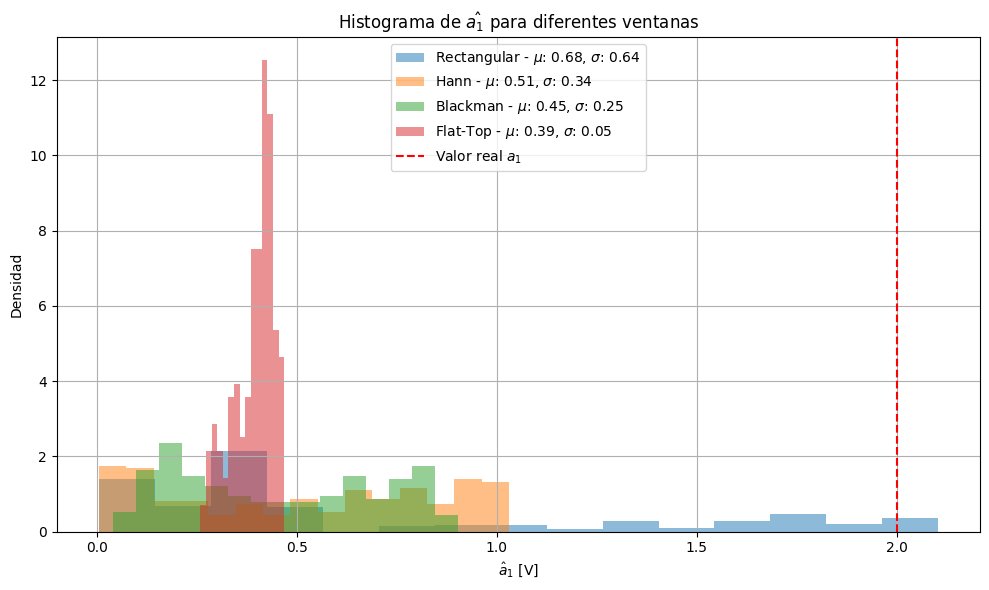

In [10]:
# -------------------------------------------------------------------------------
#                           Grafico de histogramas
# -------------------------------------------------------------------------------

resultados = []
plt.figure(figsize=(10,6))

for window_name in a1_estimates.keys():
    mean_a1_estimate = np.mean(a1_estimates[window_name])  # Media
    var_a1_estimate = np.var(a1_estimates[window_name])     # Varianza
    std_a1_estimate = np.std(a1_estimates[window_name])     # Desvio
    percent_std_a1 = (std_a1_estimate / mean_a1_estimate) * 100  # Desvio sobre la media
    sesgo_a1 = np.mean(np.array(a1_estimates[window_name]) - a1) # Sesgo
    resultados.append({
            'Ventana': window_name,
            'Media': mean_a1_estimate,
            'Sesgo': sesgo_a1,
            'Varianza': var_a1_estimate,
            'Desvio/Media [%]': percent_std_a1
        })
    df_resultados = pd.DataFrame(resultados)
    plt.hist(a1_estimates[window_name], bins=15, alpha=0.5,
             label=f'{window_name} - $\mu$: {np.mean(a1_estimates[window_name]):.2f}, $\sigma$: {np.std(a1_estimates[window_name]):.2f}', 
             density=True)

plt.title('Histograma de $\\hat{a_1}$ para diferentes ventanas')
plt.xlabel('$\hat{a}_1$ [V]')
plt.ylabel('Densidad')
plt.axvline(a1, color='red', linestyle='--', label='Valor real $a_1$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Tabla de resultados

In [11]:
styled_table = df_resultados.style.hide(axis="index").format(precision=3)
styled_table

Ventana,Media,Sesgo,Varianza,Desvio/Media [%]
Rectangular,0.681,-1.319,0.404,93.377
Hann,0.511,-1.489,0.113,65.711
Blackman,0.450,-1.550,0.064,56.255
Flat-Top,0.394,-1.606,0.003,12.706


## Analisis y conclusiones
Se genero una señal senoidal de frecuencia normalizada, y se le agregaron variaciones aleatorias en su amplitud y en su frecuencia. Se propuso hallar el valor de de amplitud, y para eso se definio un estimador $\hat{a}_1$. 

Se realizaron 4 simulaciones de 200 realizaciones cada una, en las cuales se aplicaron 4 tipos de ventanas:
* Rectangular
* Hanning
* Blackman
* Flat-Top

A partir de los resultados de las simulaciones, se observaron los siguientes resultados:
* El resultado mas cercano se obtuvo con la ventana rectangular, pero es la que presenta la mayor varianza, por lo tanto resulta poco fiable.
* El resultado mas sesgado se obtuvo con la ventana Flat-Top, que a su vez presenta la menor varianza de todas.
* Se observaron resultados similares para los casos de ventanas Hanning y Blackman, la Hanning presentando ligeras mejoras respecto al sesgo y la varianza.